# Synthetic likelihood (parametric approximation)

Florent Leclercq<br>
Imperial Centre for Inference and Cosmology, Imperial College London<br>
<a href="mailto:florent.leclercq@polytechnique.org">florent.leclercq@polytechnique.org</a>

In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline
plt.rc('lines', linewidth=2)
colors=[plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]
colors_2=[plt.cm.tab10(i) for i in np.linspace(0, 1, 10)]
plt.rc('axes', prop_cycle=cycler('color', colors))

## Setup problem

In [2]:
def simulator(mu, sigma, batch_size=10, random_state=None):
    mu, sigma = np.atleast_1d(mu, sigma)
    return ss.norm.rvs(mu[:, None], sigma[:, None], size=(1, batch_size), random_state=random_state)

def mean(y):
    return np.mean(y, axis=1)

def var(y):
    return np.var(y, axis=1)

def likelihood(mu, d0, batch_size):
    return 1/2.*np.log(2*np.pi/batch_size) + batch_size/2.*(d0 - mu)**2

def sample(mu, sigma, N):
    sims=np.zeros(N)
    for j_ in range(N):
        y_=simulator(mu, sigma)
        sims[j_]+=mean(y_)
    return np.mean(sims)

In [3]:
# Set the batch size and number of simulations per mu
batch_size=10
N=2

# Set the generating parameters that we will try to infer
mean0 = 2
sigma0 = 1

# Generate some data (using a fixed seed here)
np.random.seed(234897)
y0 = simulator(mean0, sigma0)
print(y0)
d0=mean(y0)
print(d0)

[[ 1.40440613  2.15733363  4.03025858  0.38635054  1.94687808  2.29341463
   2.79857016  1.92131005  3.98223683  2.13973219]]
[ 2.30604908]


In [4]:
# Set the prior
mu = ss.uniform(-2,6)

## Generate simulations

In [5]:
# Generate some data points
N_sims=100
mu_sims=mu.rvs(N_sims)
sims=np.zeros(N_sims)
for i_ in range(N_sims):
    sims[i_]=sample(mu_sims[i_], sigma0, N)
S1_sims=likelihood(sims,d0,batch_size)

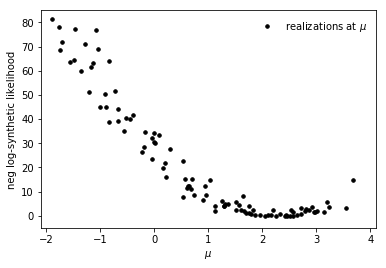

In [6]:
(xmin,xmax)=(-2.1,4.1)
(ymin,ymax)=(-5,85)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.xlabel("$\mu$")
plt.ylabel("neg log-synthetic likelihood")
plt.legend(frameon=False)

## The synthetic likelihood as a stochastic process

In [7]:
def synthetic_likelihood(mu, d0, g, batch_size):
    return 1/2.*np.log(2*np.pi/batch_size) + batch_size/2.*(d0 - mu - g)**2
# this is likelihood(d0, mu+g)
# equation (17) in Gutmann & Corander 2016

### One realization

In [8]:
# Get the synthetic likelihood for one particular realization
sigma_g=1/np.sqrt(N*batch_size)
g=ss.norm(0, sigma_g).rvs()
(xmin,xmax)=(-2.1,4.1)
mu_arr=np.linspace(xmin,xmax,200)
l_mu_one_res=synthetic_likelihood(mu_arr, d0, g, batch_size)

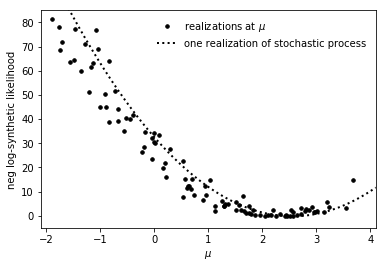

In [9]:
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.plot(mu_arr, l_mu_one_res, linestyle=":", color="black", label="one realization of stochastic process")
plt.xlabel("$\mu$")
plt.ylabel("neg log-synthetic likelihood")
plt.legend(frameon=False)

### Mean and quantiles

In [10]:
g_m=ss.norm(0, sigma_g).ppf(0.1) # g value for the 0.1 quantile
g_p=ss.norm(0, sigma_g).ppf(0.9) # g value for the 0.9 quantile
g_0=ss.norm(0, sigma_g).ppf(0.5) # g value for the mean
l_mu_m=synthetic_likelihood(mu_arr, d0, g_m, batch_size)
l_mu_p=synthetic_likelihood(mu_arr, d0, g_p, batch_size)
l_mu_0=synthetic_likelihood(mu_arr, d0, g_0, batch_size)

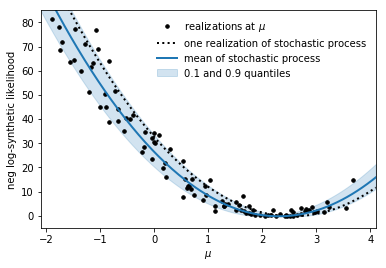

In [11]:
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.plot(mu_arr, l_mu_one_res, linestyle=":", color="black", label="one realization of stochastic process")
plt.plot(mu_arr, l_mu_0, linestyle="-", color=colors_2[0], label="mean of stochastic process")
plt.fill_between(mu_arr, l_mu_m, l_mu_p, alpha=0.2, facecolor=colors_2[0], edgecolor=colors_2[0], label="0.1 and 0.9 quantiles")
plt.xlabel("$\mu$")
plt.ylabel("neg log-synthetic likelihood")
plt.legend(frameon=False)

## Distribution of the maximum synthetic likelihood estimator

In [12]:
def max_synthetic_likelihood(d0, N):
    sigma_g=1/np.sqrt(N*batch_size)
    return ss.norm(d0, sigma_g)

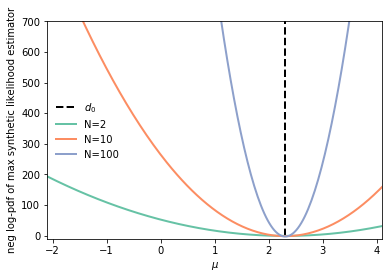

In [13]:
(ymin,ymax)=(-10,700)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.plot([d0,d0],[0,ymax], linestyle="--", color="black", label="$d_0$")
plt.plot(mu_arr, -max_synthetic_likelihood(d0, 2).logpdf(mu_arr), label="N=2")
plt.plot(mu_arr, -max_synthetic_likelihood(d0, 10).logpdf(mu_arr), label="N=10")
plt.plot(mu_arr, -max_synthetic_likelihood(d0, 100).logpdf(mu_arr), label="N=100")
plt.xlabel("$\mu$")
plt.ylabel("neg log-pdf of max synthetic likelihood estimator")
plt.legend(frameon=False,loc="best")